# Personal Project
> Nama: **Agung Besti**

> Name Project: **Movie Genre Data**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"

In [3]:
#changing the working directory
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [4]:
!kaggle datasets download -d lokkagle/movie-genre-data

movie-genre-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile
local_zip = '/content/gdrive/MyDrive/kaggle/movie-genre-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [6]:
os.listdir('/content/gdrive/MyDrive/kaggle/')

['kaggle.json', 'movie-genre-data.zip', 'kaggle_movie_train.csv']

In [7]:
#library
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.regularizers import l2
import time
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("/content/gdrive/MyDrive/kaggle/kaggle_movie_train.csv")
df.tail()

,id,text,genre
22574,28161,n in the world to decide what I'm going to do ...,drama
22575,28162,shards. BOJO LAZ! Laz pushes Deke back through...,drama
22576,28163,"OTTIE You've got a thing about Ernie's, haven'...",thriller
22577,28165,....with marked skill and dexterity . LANA wry...,action
22578,28166,"rd walks off down the hallway, leaving his pos...",comedy


Melihat sebaran kelas pada dataset

In [9]:
df['genre'].value_counts()

drama        8873
thriller     6824
comedy       2941
action       2392
sci-fi        613
horror        456
other         270
adventure     147
romance        63
Name: genre, dtype: int64

Karena ada sebaran kelas yang tidak seimbang pada dataset, maka kita hanya memilih kelas **comedy**, **action**, **sci-fi** dan **horror**. selain dari kelas itu kita hapus.

In [10]:
# Menghapus kelas selain 4 genre tersebut
df = df[~df['genre'].isin(['drama','thriller','other','adventure','romance'])]
df['genre'].value_counts()

comedy    2941
action    2392
sci-fi     613
horror     456
Name: genre, dtype: int64

sebelum memproses data, sebelumnya dilakukan pengecekan dataset tersebut. apakah ada nilai kosong atau tidak dengan fungsi isnull().

Jika true maka ada nilai kosong dan jika false maka tidak ada nilai kosong

In [11]:
df.isnull().values.any()

False

Menghapus kolom yang tidak dibutuhkan

In [12]:
# drop kolom id
df = df.drop(['id'], axis=1)
df.head()

,text,genre
1,"t, summa cum laude and all. And I'm about to l...",comedy
9,e reels as the world spins. Sweat pours off hi...,action
20,I say he's a man who'll go far. Some people s...,comedy
25,you find out where the bachelor party is? COLE...,comedy
29,ibly horrendous public break up on the quad. A...,comedy


Membuat function Text Processing, untuk membuat data lebih baik lagi.

In [13]:
#Mengubah karakter huruf kapital menjadi kecil pada setiap kalimat data latih
def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

#Menghapus tanda baca pada setiap kalimat data latih
def remove_tandabaca(words):
    new_words = []
    for word in words:
        new_word = word.translate(str.maketrans("","",string.punctuation))
        new_words.append(new_word)
    return new_words

#Menghapus jarak pada setiap kalimat data latih
def remove_space(words):
    new_words = []
    for word in words:
        new_word = word.strip()
        #re.sub(' +', ' ',new_word)
        re.sub(r"^\s+|\s+$", "", new_word)
        new_words.append(new_word)
    return new_words
#Menghapus jarak dan tanda pada setiap kalimat data latih
def text_cleaning(words):
    words = remove_tandabaca(words)
    words = remove_space(words)
    return words

def preprocessing(words):
    words = text_cleaning(words)
    words = to_lowercase(words)
    return words

Melakukan preprocessing pada dataset

In [14]:
df['text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
df['text'] = preprocessing(df['text'].values)
df.head()

,text,genre
1,t summa cum laude and all and i m about to lau...,comedy
9,e reels as the world spins sweat pours off him...,action
20,i say he s a man who ll go far some people say...,comedy
25,you find out where the bachelor party is cole ...,comedy
29,ibly horrendous public break up on the quad ag...,comedy


Pelabelan genre dengan one hot encoded

In [15]:
genre = pd.get_dummies(df.genre)
df_genre = pd.concat([df, genre], axis=1)
df_genre = df_genre.drop(columns='genre')
df_genre.head()

,text,action,comedy,horror,sci-fi
1,t summa cum laude and all and i m about to lau...,0,1,0,0
9,e reels as the world spins sweat pours off him...,1,0,0,0
20,i say he s a man who ll go far some people say...,0,1,0,0
25,you find out where the bachelor party is cole ...,0,1,0,0
29,ibly horrendous public break up on the quad ag...,0,1,0,0


In [16]:
# Mengubah tipe data menjadi str
text = df_genre['text'].astype(str)
label = df_genre[['action', 'comedy','horror','sci-fi']].values

Membagi dataset menjadi data **train 80%** dan **validation 20%**

In [17]:
text_train, text_test, kelas_train, kelas_test = train_test_split(text, label, test_size = 0.2)

mengkonversikan setiap text ke sequence

In [18]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_test)
 
sekuens_train = tokenizer.texts_to_sequences(text_train)
sekuens_test = tokenizer.texts_to_sequences(text_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

Pemodelan Sequential dengan layer Embedding dan LSTM

In [19]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=16),
    LSTM(64),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [20]:
#Membuat fungsi recall untuk mengukur tingkat keberhasilan sistem dalam menemukan kembali sebuah informasi.
def rec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
#Membuat fungsi Precision untuk mengukur tingkat ketepatan antara informasi yang diminta. 
def prec(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [22]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'nadam',
              metrics=['accuracy', prec, rec])

Melakukan pelatihan model Nadam

In [23]:
#Model Adam
print("\nStart Training Model Nadam\n")
start_time = time.time()
history = model.fit(
    padded_train, 
    kelas_train,
    epochs = 100,
    validation_data = (padded_test, kelas_test),
    verbose =2,
    batch_size = 16,
    callbacks=[callbacks]
)
print("\nStop Training")
timenadam = ((time.time() - start_time)/60)
print("Duration Learning : ",((time.time() - start_time)/60))


Start Training Model Nadam

Epoch 1/100
321/321 - 36s - loss: 1.1222 - accuracy: 0.4564 - prec: 0.4848 - rec: 0.1746 - val_loss: 0.9330 - val_accuracy: 0.5105 - val_prec: 0.5751 - val_rec: 0.4267
Epoch 2/100
321/321 - 36s - loss: 0.8520 - accuracy: 0.5522 - prec: 0.5884 - rec: 0.4011 - val_loss: 0.8543 - val_accuracy: 0.5699 - val_prec: 0.5936 - val_rec: 0.4498
Epoch 3/100
321/321 - 36s - loss: 0.7397 - accuracy: 0.6278 - prec: 0.6468 - rec: 0.5541 - val_loss: 0.9437 - val_accuracy: 0.4629 - val_prec: 0.4653 - val_rec: 0.4043
Epoch 4/100
321/321 - 35s - loss: 0.6743 - accuracy: 0.7061 - prec: 0.7357 - rec: 0.6419 - val_loss: 0.7976 - val_accuracy: 0.6721 - val_prec: 0.7204 - val_rec: 0.5694
Epoch 5/100
321/321 - 35s - loss: 0.4922 - accuracy: 0.8039 - prec: 0.8328 - rec: 0.7710 - val_loss: 0.8193 - val_accuracy: 0.6565 - val_prec: 0.6896 - val_rec: 0.6250
Epoch 6/100
321/321 - 36s - loss: 0.4808 - accuracy: 0.8077 - prec: 0.8321 - rec: 0.7790 - val_loss: 0.7780 - val_accuracy: 0.6393 

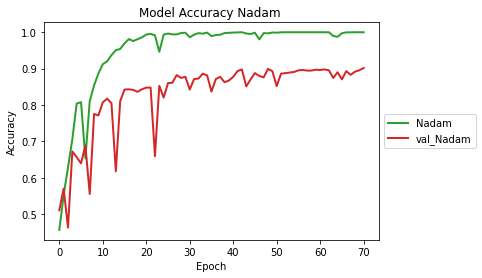

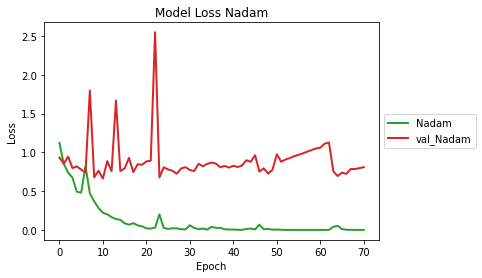

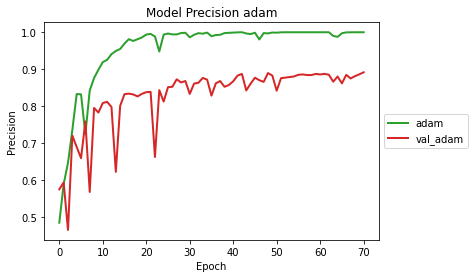

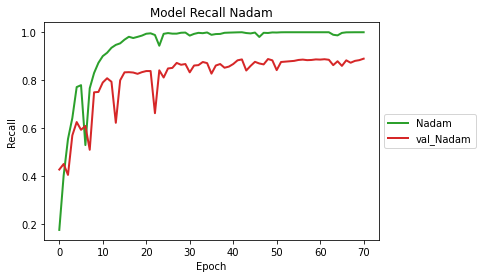

In [24]:
# visualisasi hasil data training
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f','#bcbd22', '#17becf']
#Nadam
acc_adam = history.history['accuracy']
val_acc_adam = history.history['val_accuracy']
loss_adam = history.history['loss']
val_loss_adam = history.history['val_loss']
prec_adam = history.history['prec']
val_prec_adam = history.history['val_prec']
rec_adam = history.history['rec']
val_rec_adam = history.history['val_rec']

# Visualisasi Accuracy Model
plt.plot(acc_adam, label='Nadam', color=new_colors[2],linewidth=2)
plt.plot(val_acc_adam, label='val_Nadam', color=new_colors[3],linewidth=2)
plt.title('Model Accuracy Nadam ')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# Visualisasi Loss Model
plt.plot(loss_adam, label='Nadam', color=new_colors[2],linewidth=2)
plt.plot(val_loss_adam, label='val_Nadam', color=new_colors[3],linewidth=2)
plt.title('Model Loss Nadam')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# Visualisasi Precision Model
plt.plot(prec_adam, label='adam', color=new_colors[2],linewidth=2)
plt.plot(val_prec_adam, label='val_adam', color=new_colors[3],linewidth=2)
plt.title('Model Precision adam')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()
# Visualisasi Recall Model
plt.plot(rec_adam, label='Nadam', color=new_colors[2],linewidth=2)
plt.plot(val_rec_adam, label='val_Nadam', color=new_colors[3],linewidth=2)
plt.title('Model Recall Nadam')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()